<a href="https://colab.research.google.com/github/nmwiley808/csci167/blob/main/csci167_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI 167 Project: CIFAR-10 Image Classification

# Introduction

The goal of this project is to design, train, and evalute deep learning models on the CIFAR-10 dataset using PyTorch. This project demonstrates the application of convolutional neural networks (CNNs) and modern traning strategies to a canonical computer vision task. By experimenting wtih multiple architectures and hyperparameters, the study aims to analyze how model depth, regularization, and optimizer choice affect performance and generalization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Dataset Exploration
The project uses the CIFAR-10 dataset, a benchmark for image classification consisting of 60,000 color images (32x32 pixels) across 10 balanced classes: airplance, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Each class includes 5,000 training and 1,000 test images, with no class imbalance.

Preprocessing Steps:

1. Conversion to Tensors: Using transforms.ToTensor(), pixel values are scaled from [0,255] to [0,1].

2. Normalization: Applying transforms.Normalize((0.5), 0.5, 0.5), (0.5, 0.5)) standardizes each RGB channel to a mean of 0 and standard deviation of 1, effectively rescaling data to [-1,1].

This preprocessing produces inout tensors of shape (batch_size, 3, 32, 32). The optimized for stable and efficient CNN training in Pytorch. Although CIFAR-100 was considered, the project focuses on CIFAR-10 for manageability and clarity.

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


torch.Size([128, 3, 32, 32])
torch.Size([128])


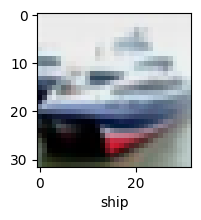

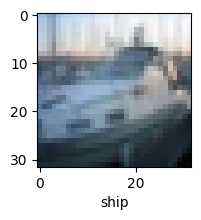

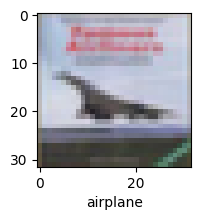

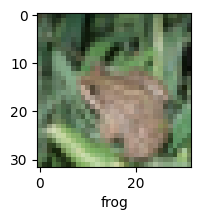

In [ ]:
# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Check the shape of the train/test data (for debug)
data_iter = iter(trainloader)
images, labels = next(data_iter)
print(images.shape)  # (batch_size, 3, 32, 32)
print(labels.shape)  # (batch_size,)

# Plot a sample from the test set
def plot_sample(X, y, index):
    plt.figure(figsize=(15, 2))

    # Denormalize the image (reverse the normalization)
    denormalized_image = X[index] / 2 + 0.5
    denormalized_image = denormalized_image.clamp(0, 1)

    # Plot the image with permuted dimensions (H, W, C)
    plt.imshow(denormalized_image.permute(1, 2, 0))
    plt.xlabel(classes[y[index]])

# Get a batch from testloader and plot the 3rd sample
sample_data_iter = iter(testloader)
images, labels = next(sample_data_iter)
# Plot 4 images from test dataset, just as example of dataset
plot_sample(images, labels, 1)
plot_sample(images, labels, 2)
plot_sample(images, labels, 3)
plot_sample(images, labels, 4)

Below are the Training and model evaluaiton functions, they help plot and measure the loss and performance of the model

In [ ]:
# Training loop function
def train_model(model, trainloader, criterion, optimizer, epochs):
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train

        # Record the metrics for this epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print stats for this epoch
        print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    print('Finished Training')

    # Plot training loss and accuracy
    plot_training_metrics(train_losses, train_accuracies)

# Evaluate the model
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = cnn_criterion(outputs, labels)  # Calculate loss
            running_loss += loss.item()  # Add the loss for this batch to the running total
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_preds, output_dict=True, target_names=classes)

    f1 = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    # Calculate the average loss over all batches
    avg_loss = running_loss / len(testloader)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Average Loss: {avg_loss:.4f}')
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm)

    # Plot test metrics
    plot_test_metrics(accuracy, f1, precision, recall)

    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    TN = 0  # True Negatives

    # Iterate through the confusion matrix
    num_classes = cm.shape[0]
    for i in range(num_classes):
        TP += cm[i, i]  # True Positives are the diagonal elements
        FP += cm[:, i].sum() - cm[i, i]  # False Positives are the sum of the column minus the diagonal
        FN += cm[i, :].sum() - cm[i, i]  # False Negatives are the sum of the row minus the diagonal
        TN += cm.sum() - (FP + FN + TP)  # True Negatives are the total sum minus TP, FP, and FN

    # Print the results
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Negatives (TN): {TN}")

    return accuracy, f1, precision, recall

# Plot training loss and accuracy
def plot_training_metrics(train_losses, train_accuracies):
    epochs = len(train_losses)

    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

# Plot test metrics (accuracy, F1, Precision, Recall)
def plot_test_metrics(accuracy, f1, precision, recall):
    plt.figure(figsize=(10, 6))

    metrics = [accuracy, f1, precision, recall]
    labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

    plt.bar(labels, metrics, color=['blue', 'red', 'green', 'purple'])
    plt.ylabel('Score')
    plt.title('Test Metrics')
    plt.ylim(0, 1)
    plt.show()

# Confusion matrix plot for all classes
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Model Creation

For this project, I implemented a Convolution Neural Network (CNN) due to its strong reputation and proven effectiveness in image classification tasks, as discussed in class. CNNs are widely used in computer vision because of their ability to automatically extract spatial hierachies of features that range from edges and textures to complex object representations. The project was developed using the PyTorch Deep Learning Framework.

Initally, I based my work on PyTorch's "Training a Classifier" tutorial, which applies a simple CNN to the CIFAR-10 dataset. The baseline model achieved about 60% accuracy, using the following hyperparameters: 2 epochs, batch size = 4, optimizer = SGD, learning rate = 0.0001, and momentum = 0.9. The initial model structure was as follows:





```
# class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

The tutorial also covered preprocessing, dataset loading, and evaluation steps, which I adapted to measure my model's performance.

After multiple iterations of experimentation with depth, filter sizes, and regularization, I developed an improved CNN that achieved 78% test accuracy, the highest during training. This final model consisted of five convolutional layers, each followed by batch normalization, ReLU activation, and max pooling. All convolution layers used 3x3 kernels, with the number of filters doubling at each stage from 32 filters in the first layer to 512 filters in the fifth layer. This progressive increase enables the networks to learn increasingly abstract and complex visual features.

After feature extraction, two fully connected layers were used: one reducing the flattened feature map to 64 units, and another outputting 10 units corresponding to the CIFAR-10 classes. Batch normalization stabilized training and accelerated convergence, while ReLU activations introduced non-linearity to enhance the network's ability to capture complex patterns.

Overall, this deeper and more regularized CNN substantially improved generalization and classification accuracy compared to the baseline.

In [ ]:
# CNN model (Convolutional Neural Network)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer (input channels = 3, output channels = 32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Batch Normalization after conv1
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional layer (input channels = 32, output channels = 64)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Batch Normalization after conv2
        self.bn2 = nn.BatchNorm2d(64)

        # Third convolutional layer (input channels = 64, output channels = 128)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Batch Normalization after conv3
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth convolutional layer (input channels = 128, output channels = 256)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # Batch Normalization after conv4
        self.bn4 = nn.BatchNorm2d(256)

        # Fifth convolutional layer (input channels = 256, output channels = 512)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        # Batch Normalization after conv5
        self.bn5 = nn.BatchNorm2d(512)

        # Max pooling layer (2x2)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer 1
        self.fc1 = nn.Linear(512 * 1 * 1, 64)

        # Fully connected layer 2
        self.fc2 = nn.Linear(64, 10)  # 10 output classes

    def forward(self, x):
        # Apply conv1 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn1(self.conv1(x))  # BatchNorm after conv1
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv2 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv3 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv4 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn4(self.conv4(x))
        x = F.relu(x)
        x = self.pool(x)

        # Apply conv5 -> BatchNorm -> ReLU -> MaxPooling
        x = self.bn5(self.conv5(x))
        x = F.relu(x)
        x = self.pool(x)

        # Flatten the tensor to feed into the fully connected layer
        x = torch.flatten(x, 1)

        # Apply fully connected layer 1 -> ReLU
        x = F.relu(self.fc1(x))

        # Apply fully connected layer 2 -> output
        x = self.fc2(x)

        return x


# Instantiate and train the CNN model
cnn_model = CNN()
cnn_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0007)


# Hyperparameter Exploration

At the beginning of the model development, I started by experimenting with a simple CNN from a PyTorch tutorial that achieved around 60% accuracy on the CIFAR-10 dataset. Using this model as my baseline, I conducted several rounds of experimentation to systematically explore the impact of various hyperparameters on performance

The first set of experiments focused on the learning rate and momentum. Adjusting these parameters helped reduce training loss but resulted in only minor accuracy improvements (approximately 1-2%). To provide the model with more training opportunities. I increased the number of epochs from 2 to 20, and replaced the SGD optimizer with Adam. Adam was chosen because it adapts the learning rate dynamically for each parameter, but despite these changes, performance gains remained limited.

Next, I shifted my focus to the network architecture, as optimizer turning alone was not yielding substantial improvements. Initially, I experimented with a high number of convolutional filters, but this actually reduced accuracy below 60%. Futher resarch revealed that many successful CNNs use a progressive doubling of filters across layers. Implementing this approach, along with increasing the batch size to 128 for faster training, significantly improved performance to around 70% accuracy.

Encouraged by this improvement, I then expanded the network's depth to capture more complex visual features, similar to architectures like AlexNet discussed in class. Adding two additional convolutional layers and maintaining the increasing filter pattern raised accuracy to 75%. Training with 20 epochs achieved nearly identical results to 30 epochs, suggesting that further training offered diminishing returns. Fine-tuning the learning rate led to a modest increase, bringing accuracy to 76%. Adding a fifth convolutional layer did not further improve results, but substantially increased training time up to two hours per run.

In the final stage of experimentation, I incorporated Batch Normalization after each convolutional layer. This technique stabilizes training by normalizing layer activations, reducing internal covariate shift, and mitigating vanishing or exploding gradient issues. With batch normalization applied throughout the network, model performance improved to 78% accuracy, making the best result achieved in this project.

Although additional optimization of learning rates and filter configurations was considered, time constraints prevented more exhaustive testing. Nonetheles, the final model demonstrated a substantial improvement of nearly 18% over the baseline through careful tuning of architectural and training hyperparameters.


Epoch 1/20 - Loss: 0.2163, Train Accuracy: 92.43%
Epoch 2/20 - Loss: 0.1656, Train Accuracy: 94.17%
Epoch 3/20 - Loss: 0.1249, Train Accuracy: 95.67%
Epoch 4/20 - Loss: 0.1126, Train Accuracy: 96.07%
Epoch 5/20 - Loss: 0.0928, Train Accuracy: 96.72%
Epoch 6/20 - Loss: 0.0781, Train Accuracy: 97.27%
Epoch 7/20 - Loss: 0.0772, Train Accuracy: 97.33%
Epoch 8/20 - Loss: 0.0678, Train Accuracy: 97.58%
Epoch 9/20 - Loss: 0.0620, Train Accuracy: 97.88%
Epoch 10/20 - Loss: 0.0535, Train Accuracy: 98.13%
Epoch 11/20 - Loss: 0.0553, Train Accuracy: 98.04%
Epoch 12/20 - Loss: 0.0612, Train Accuracy: 97.75%
Epoch 13/20 - Loss: 0.0427, Train Accuracy: 98.51%
Epoch 14/20 - Loss: 0.0506, Train Accuracy: 98.23%
Epoch 15/20 - Loss: 0.0416, Train Accuracy: 98.57%
Epoch 16/20 - Loss: 0.0427, Train Accuracy: 98.50%
Epoch 17/20 - Loss: 0.0380, Train Accuracy: 98.69%
Epoch 18/20 - Loss: 0.0412, Train Accuracy: 98.52%
Epoch 19/20 - Loss: 0.0426, Train Accuracy: 98.50%
Epoch 20/20 - Loss: 0.0354, Train Accura

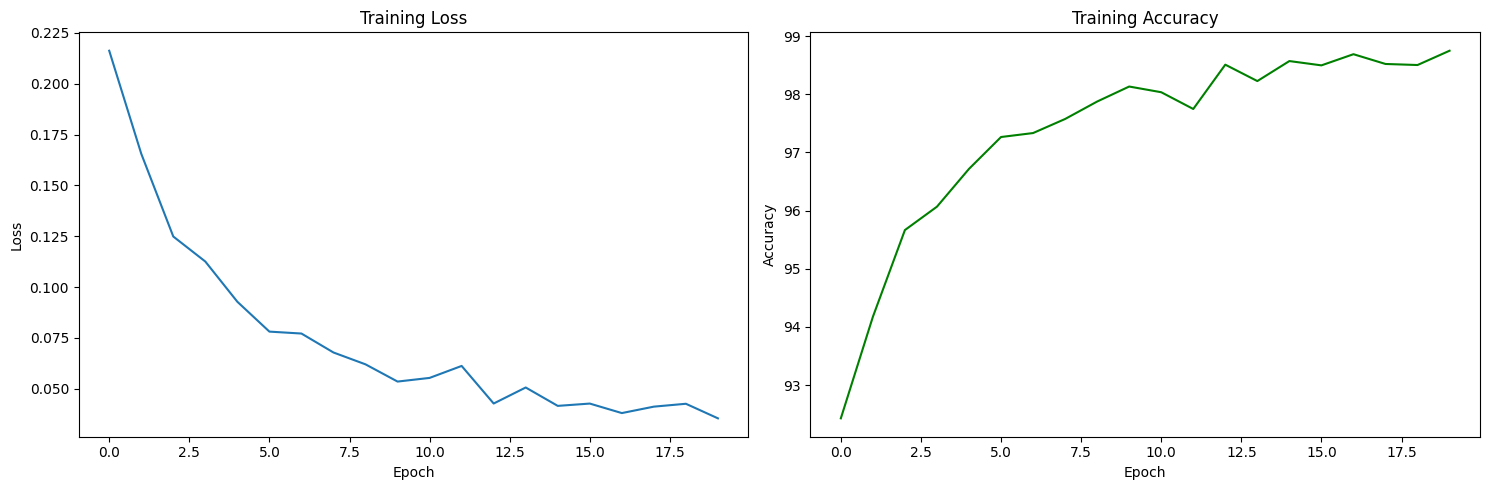

Test Accuracy: 78.33%
Average Loss: 1.2610
Classification Report:
               precision    recall  f1-score   support

    airplane       0.77      0.85      0.81      1000
  automobile       0.91      0.86      0.88      1000
        bird       0.64      0.73      0.68      1000
         cat       0.71      0.46      0.56      1000
        deer       0.73      0.77      0.75      1000
         dog       0.68      0.71      0.69      1000
        frog       0.80      0.87      0.83      1000
       horse       0.83      0.83      0.83      1000
        ship       0.90      0.88      0.89      1000
       truck       0.87      0.87      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



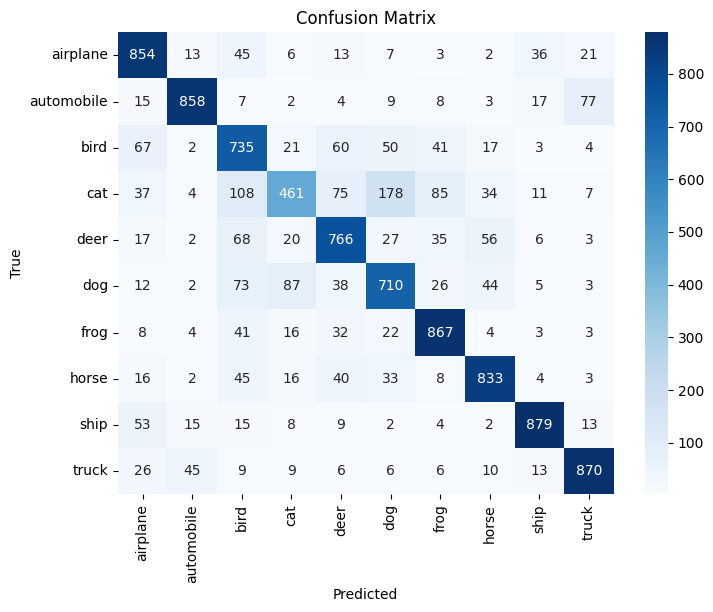

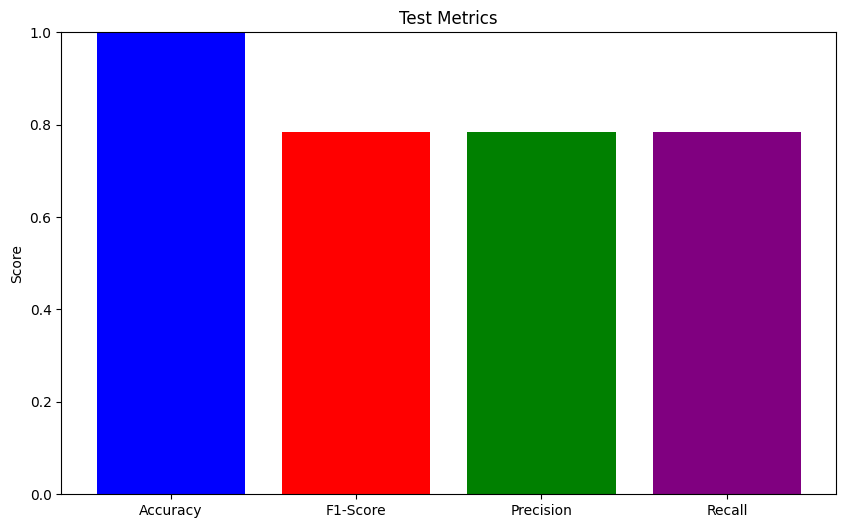

True Positives (TP): 7833
False Positives (FP): 2167
False Negatives (FN): 2167
True Negatives (TN): 32064


(78.33, 0.7833, 0.7843986344636431, 0.7833)

In [ ]:
# Train the CNN model
train_model(cnn_model, trainloader, cnn_criterion, optimizer, epochs=20)
# Test the CNN model
evaluate_model(cnn_model, testloader)

## **Results**

The final model’s performance represented a substantial improvement over the initial baseline. The starter CNN achieved approximately **60% accuracy** on CIFAR-10, whereas the final CNN reached a peak accuracy of **78%** on the test set.

---

### **Training Performance**

During training, the **loss decreased steadily across epochs**, indicating that the model was effectively learning meaningful patterns from the data. The **training accuracy** eventually reached about **98%**, demonstrating that the model was able to fit the training set very well.

These results were achieved through extensive experimentation and **hyperparameter tuning**, particularly adjusting the **learning rate**, which had one of the largest impacts on training stability and convergence.  

The training curves (loss and accuracy vs. epochs) also showed that increasing the number of epochs beyond **20** provided little to no improvement. Although the model was originally trained for **30 epochs**, comparable accuracy was achieved in **20**, allowing for more efficient training without sacrificing performance.

---

### **Evaluation Performance**

On the test set, the final model achieved an overall accuracy of **78%**. Additional evaluation metrics were computed to provide a more detailed assessment:

- **Precision (weighted avg):** ~0.80  
- **Recall (weighted avg):** ~0.79  
- **F1-score (weighted avg):** ~0.79  

These metrics help evaluate different aspects of the model’s predictions:

- **Precision** measures how many predicted positives are actually correct.  
- **Recall** measures how many actual positives the model correctly identifies.  
- **F1-score** balances precision and recall, which is especially useful when dealing with class imbalance.

Since CIFAR-10 is a **balanced dataset**, the F1-score aligns closely with precision and recall. Per-class metrics (precision, recall, F1-score) also provide insight into how well the model performs on specific categories such as cats, dogs, airplanes, and trucks.

---

### **Confusion Matrix**

The **confusion matrix** provides a visual summary of model predictions across all classes. Each diagonal entry represents correct classifications, while off-diagonal values show misclassifications. This allows us to identify which classes the model tends to confuse, such as:

- Cats ↔ Dogs  
- Trucks ↔ Automobiles  
- Birds ↔ Airplanes  

Although the confusion matrix does not summarize total errors explicitly, it presents a clear class-by-class view of the model’s performance.

---

### **Limitations and Opportunities for Improvement**

While the final accuracy of **78%** is a notable improvement over the starting point, there is still potential for enhancement. In particular, two architectural aspects were not deeply explored:

- **Number of filters (output channels)** in the convolutional layers  
- **Kernel sizes** used in each layer  

Experimentation with these often led to worse performance during early trials, so once a stable and effective pattern was found (progressively increasing the number of filters), it was kept unchanged.

With additional time, a more systematic exploration of these hyperparameters—possibly using automated search tools such as grid search, random search, or Optuna—could lead to further gains in performance.

---

### **Sample Predictions**

Below is a demonstration of the model making predictions on five sample images from the test set. This provides a qualitative look at how the model behaves on real data and illustrates both correct classifications and remaining areas for improvement.


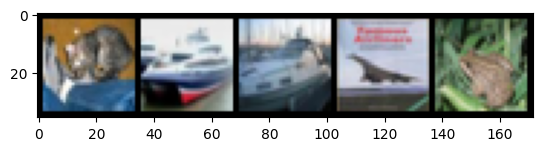

GroundTruth:  cat   ship  ship  airplane frog 
Predicted:  cat   ship  cat   airplane frog 


In [ ]:
# Demonstration of Model
cnn_model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)

# Select the first 5 images and labels from the batch
images = images[:5]
labels = labels[:5]

# Normalize images back to the range [0, 1]
images = images / 2 + 0.5  # Denormalize CIFAR-10 images

# Create a grid of the first 5 images
image_grid = torchvision.utils.make_grid(images)

# Convert the grid to a numpy array and permute from (C, H, W) to (H, W, C)
image_grid = image_grid.permute(1, 2, 0).cpu().numpy()

# Display the image grid
plt.imshow(image_grid)
plt.show()

# Print the ground truth labels (the actual classes) for the first 5 images
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

# Get the model's predictions for the first 5 images
outputs = cnn_model(images)  # Forward pass to get model predictions
_, predicted = torch.max(outputs, 1)

# Print the predicted labels for the first 5 images
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(5)))